In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install gdown 

In [2]:
!gdown 1JDgLpem1jxqnkYROui7bf0y0F4iMzhne

Downloading...
From (original): https://drive.google.com/uc?id=1JDgLpem1jxqnkYROui7bf0y0F4iMzhne
From (redirected): https://drive.google.com/uc?id=1JDgLpem1jxqnkYROui7bf0y0F4iMzhne&confirm=t&uuid=f92c05c6-fbd4-423e-a080-caf9d99c1679
To: /kaggle/working/ibug_300W_large_face_landmark_dataset.zip
100%|██████████████████████████████████████| 1.15G/1.15G [00:30<00:00, 37.5MB/s]


In [ ]:
!unzip /kaggle/working/ibug_300W_large_face_landmark_dataset.zip 

In [5]:
import xml.etree.ElementTree as ET

#load and parse the XML file
tree = ET.parse('./kaggle/working/ibug_300W_large_face_landmark_dataset/labels_ibug_300W.xml')
root = tree.getroot()

# Print the root tag and its attributes
print(f"Root tag: {root.tag}, attributes: {root.attrib}")

# Iterate through elements
for child in root:
    print(f"Tag: {child.tag}, attributes: {child.attrib}")



Root tag: dataset, attributes: {}
Tag: name, attributes: {}
Tag: comment, attributes: {}
Tag: images, attributes: {}


In [6]:
images_data = root.find('images')
# for child in images_data:
#     print(f"Tag: {child.tag}, attributes: {child.attrib}")
image_sample = images_data.find('image')
for child in image_sample:
    print(f"Tag: {child.tag}, attributes: {child.attrib}")

Tag: box, attributes: {'top': '206', 'left': '469', 'width': '216', 'height': '216'}


In [8]:
import numpy as np

In [9]:
def sample_image(image):
    box = image.find('box')
     # set up landmarks
    landmarks = np.array( [ [float(part.attrib["x"]), float(part.attrib["y"])] for part in box ] )
        
        # crop (landmarks: pixels cordinate)
    box_top = int( box.attrib["top"] )
    box_left = int( box.attrib["left"] )
    
    
    return dict(
            filename = image.attrib["file"],
            width = int( image.attrib["width"] ),
            height = int( image.attrib["height"] ),
            box_top = box_top,
            box_left = box_left,
            box_width = int( box.attrib["width"] ),
            box_height = int( box.attrib["height"] ),
            landmarks = landmarks # np.array
        )

In [10]:
def create_samples_xml(xml_file_path):
    tree = ET.parse(xml_file_path)
    root = tree.getroot()
    images = root.find('images')
    samples : list[dict] = [sample_image(image) for image in images]
    return samples

In [11]:
samples_train = create_samples_xml('./kaggle/working/ibug_300W_large_face_landmark_dataset/labels_ibug_300W_train.xml')
samples_test = create_samples_xml('./kaggle/working/ibug_300W_large_face_landmark_dataset/labels_ibug_300W_test.xml')

In [12]:
from PIL import Image, ImageDraw
import os
import matplotlib.pyplot as plt 

In [13]:
root_dir = './kaggle/working/ibug_300W_large_face_landmark_dataset'

In [14]:
def visualize_image(sample):
    # Open the image
    image_path = os.path.join(root_dir, sample['filename'])
    if os.path.exists(image_path):
        
        image = Image.open(image_path).convert("RGB")
#     image = 
    
    # Get image dimensions and box coordinates
        width = sample['width']
        height = sample['height']
        box_left = sample["box_left"]
        box_top = sample["box_top"]
        box_width = sample["box_width"]
        box_height = sample["box_height"]
        landmarks = sample['landmarks'] 

        # Draw bounding box
        draw = ImageDraw.Draw(image)
        box = [box_left, box_top, box_left + box_width, box_top + box_height]
        draw.rectangle(box, outline="red", width=3)

        # Draw landmarks
        for (x, y) in landmarks:
            draw.ellipse((x-2, y-2, x+2, y+2), fill='blue', outline='blue')

        # Display the image
        plt.imshow(image)
        plt.axis('off')  # Hide axes
        plt.show()

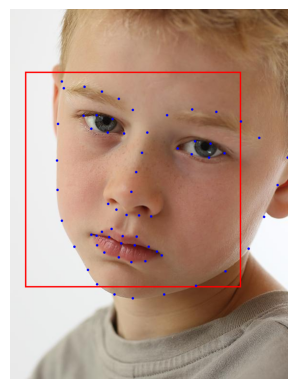

In [15]:
visualize_image(samples_train[1])

In [16]:
def get_data(samples):
    images = []
    landmarks_list = []
    for sample in samples: 
        image_path = os.path.join(root_dir, sample['filename'])
        if os.path.exists(image_path):
        
            image = Image.open(image_path).convert("RGB")
            width = sample['width']
            height = sample['height']
            box_left = sample["box_left"]
            box_top = sample["box_top"]
            box_width = sample["box_width"]
            box_height = sample["box_height"]
            landmarks = sample['landmarks']
            crop_image = image.crop( (box_left, box_top, box_left+box_width, box_top+box_height) )
            landmarks -= np.array( [box_left, box_top] )
            images.append(crop_image)
            landmarks_list.append(landmarks)
    
    return images, landmarks_list

In [17]:
def visualize_data(image,landmark):
    image_clone = image.copy()
    draw = ImageDraw.Draw(image_clone)
    for (x, y) in landmark:
        draw.ellipse((x-2, y-2, x+2, y+2), fill='blue', outline='blue')

    # Display the image
    plt.imshow(image_clone)
    plt.axis('off')  # Hide axes
    plt.show()

In [18]:
images_train, landmarks_train = get_data(samples_train)
images_test, landmarks_test = get_data(samples_test)

In [19]:
print(len(images_train))
print(len(images_test))

4332
598


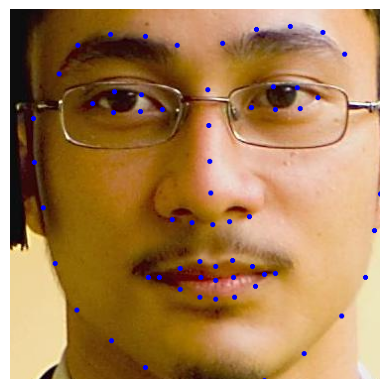

In [20]:
visualize_data(images_train[5], landmarks_train[5])

In [21]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

transform_train = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
    A.Resize(height=256, width=256, always_apply=True),
    A.RandomCrop(height=224, width=224, always_apply=True),
    A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
#     A.Cutout(num_holes=8, max_h_size=18, max_w_size=18, p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))
transform_test = A.Compose([
    A.Resize(height=256, width=256, always_apply=True),
    A.CenterCrop(height=224, width=224, always_apply=True),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))

In [22]:
def norm_transform_dataset(images,landmarks,transform):
    final_images = []
    final_landmarks = []
    
    for i in range(len(images)):
        img = images[i]
        ldm = landmarks[i]
        
        img = np.array(img)
        
        #transform
        transformed = transform(image = img, keypoints = ldm)
        transformed_img = transformed['image']
        transformed_lmd = transformed['keypoints']
        
        #normalize
        color_channels, height, width = transformed_img.shape
        transformed_lmd = transformed_lmd / np.array([width, height]) - 0.5
        
        final_images.append(transformed_img)
        final_landmarks.append(transformed_lmd)
    
    return final_images, final_landmarks
        

In [23]:
import torch

In [24]:
def visualize_final(transformed_cropped_image,normalized_transformed_landmarks ):
    # Define mean and std
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    # Reverse color transform
    def denormalize(image_tensor, mean=mean, std=std):
        # Clone and permute the tensor
        tmp = image_tensor.clone().permute(1, 2, 0)

        # Denormalize
        for t, m, s in zip(tmp, mean, std):
            t.mul_(s).add_(m)

        # Clamp the values
        return torch.clamp(tmp, 0, 1)
    cropped_image = denormalize(transformed_cropped_image)

    # Get size of cropped image
    cropped_image = (cropped_image.numpy() * 255).astype(np.uint8)
    height, width, color_channels = cropped_image.shape

    # Denormalize landmarks to pixel coordinates
    landmarks = (normalized_transformed_landmarks + 0.5) * np.array([width, height])
    
    visualize_data(Image.fromarray(cropped_image.astype(np.uint8)).convert('RGB'), landmarks)

In [25]:
final_images_train, final_landmarks_train = norm_transform_dataset(images_train, landmarks_train,transform_train)

In [26]:
final_images_test, final_landmarks_test = norm_transform_dataset(images_test, landmarks_test,transform_test)

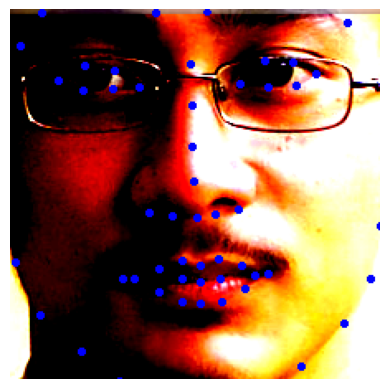

In [27]:
visualize_final(final_images_train[5],final_landmarks_train[5])

In [28]:
print(type(final_images_train))
print(type(final_landmarks_train))

<class 'list'>
<class 'list'>


In [29]:
final_images_train_converted = torch.stack([tensor.permute(1, 2, 0) for tensor in final_images_train])
final_landmarks_train = np.array(final_landmarks_train)

final_images_test_converted = torch.stack([tensor.permute(1, 2, 0) for tensor in final_images_test])
final_landmarks_test = np.array(final_landmarks_test)

In [30]:
print(type(final_images_train_converted))
print(type(final_landmarks_train))

<class 'torch.Tensor'>
<class 'numpy.ndarray'>


# MODEL
 Nhiệm vụ 
- [ ]  Sử dụng mạng Resnet18,50,256… ResNext, vgg,EfficientNet training với dữ liệu (custom output layers, sử dụng transfer-learning)
- [ ]  Define loss (MSE, MAE)
- [ ]  Training
- [ ]  save checkpoint
- [ ]  Visualize history

Dưới đây là mẫu training sử dụng Resnet50 không sử dụng transfer-learning. 

In [31]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

2024-06-02 10:43:54.598864: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-02 10:43:54.599005: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-02 10:43:54.725722: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [32]:
resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [33]:
resnet50.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [34]:
x = resnet50.output
x = GlobalAveragePooling2D()(x)  # Add a global spatial average pooling layer
x = Dense(136, activation='linear')(x)  # Add a fully connected layer with 136 units

# Reshape the output to (68, 2)
output = Reshape((68, 2))(x)

# Define the new model
model = Model(inputs=resnet50.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Summary of the model
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,866,376 (91.04 MB)

 Trainable params: 23,813,256 (90.84 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [35]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [36]:
optimizer = Adam(learning_rate=0.001)
checkpoint = ModelCheckpoint(
    filepath='model_checkpoint.keras',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)
# Train the model
history = model.fit(final_images_train_converted, final_landmarks_train, batch_size=32, epochs=50, validation_data=(final_images_test_converted, final_landmarks_test),callbacks=[checkpoint])

Epoch 1/50


I0000 00:00:1717325188.481814     211 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - loss: 0.0758
Epoch 1: val_loss improved from inf to 0.03751, saving model to model_checkpoint.keras
136/136 ━━━━━━━━━━━━━━━━━━━━ 153s 595ms/step - loss: 0.0754 - val_loss: 0.0375
Epoch 2/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - loss: 0.0028
Epoch 2: val_loss improved from 0.03751 to 0.01211, saving model to model_checkpoint.keras
136/136 ━━━━━━━━━━━━━━━━━━━━ 41s 302ms/step - loss: 0.0028 - val_loss: 0.0121
Epoch 3/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - loss: 0.0018
Epoch 3: val_loss improved from 0.01211 to 0.00657, saving model to model_checkpoint.keras
136/136 ━━━━━━━━━━━━━━━━━━━━ 40s 295ms/step - loss: 0.0018 - val_loss: 0.0066
Epoch 4/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - loss: 0.0013
Epoch 4: val_loss improved from 0.00657 to 0.00266, saving model to model_checkpoint.keras
136/136 ━━━━━━━━━━━━━━━━━━━━ 41s 298ms/step - loss: 0.0013 - val_loss: 0.0027
Epoch 5/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - loss: 